### Data wrangle

In [77]:
# Grab Data
from datetime import datetime as dt
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [78]:
# Collect user input for stock symbols
# user_input = input("Enter the symbols of the stocks you are interested in (comma-separated): ")
# symbols = user_input.split(",")

# Create a Portfolio
symbols = ['PFE','GSK','AZN','BMY','MRK','RHHBY','SNY','NVS','ABBV','JNJ']

In [79]:
# Get the stock data
# tz = pytz.timezone("America/New_York")
# start = tz.localize(dt(2000,1,1))
# end = tz.localize(dt.today())

# portfolio = yf.download(symbols,start, end, auto_adjust=True)['Adj Close']
portfolio = yf.download(symbols, period = '20y')['Adj Close']
portfolio.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,ABBV,AZN,BMY,GSK,JNJ,MRK,NVS,PFE,RHHBY,SNY
Date,,,,,,,,,,
2004-04-27,NaN,10.938019,11.693060,15.811594,31.023716,21.779404,20.355764,15.804037,7.201419,14.654794
2004-04-28,NaN,10.760674,12.052556,15.484397,30.926708,21.866991,19.873285,15.561164,7.040345,14.047167
2004-04-29,NaN,10.914985,11.967406,15.769748,30.875341,21.654938,20.263861,15.426721,7.080614,14.592595
2004-04-30,NaN,11.020936,11.872808,15.978992,30.835392,21.664165,20.585510,15.509126,7.097393,15.168105
2004-05-03,NaN,11.020936,12.114049,16.077911,31.349031,21.986822,20.613079,15.708627,6.986652,15.119334


In [80]:
# SP500 ETF Benchmark
market_prices = yf.download("SPY", period = '20y')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2004-04-27    77.990669
2004-04-28    76.980827
2004-04-29    76.305336
2004-04-30    75.711685
2004-05-03    76.523666
Name: Adj Close, dtype: float64

In [81]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'PFE': 143828500480,
 'GSK': 83988963328,
 'AZN': 233060073472,
 'BMY': 90900176896,
 'MRK': 332333514752,
 'RHHBY': 194305720320,
 'SNY': 122650591232,
 'NVS': 198817546240,
 'ABBV': 282631143424,
 'JNJ': 352165232640}

### Setting up priors

In [82]:
# Compute daily returns
returns = portfolio.pct_change().dropna()

# Calculate covariance matrix
cov_matrix = returns.cov()

# Display covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.000276  0.000087  0.000108  0.000075  0.000082  0.000095  0.000078   
AZN     0.000087  0.000236  0.000082  0.000105  0.000065  0.000076  0.000093   
BMY     0.000108  0.000082  0.000227  0.000071  0.000076  0.000078  0.000067   
GSK     0.000075  0.000105  0.000071  0.000156  0.000063  0.000078  0.000082   
JNJ     0.000082  0.000065  0.000076  0.000063  0.000121  0.000078  0.000060   
MRK     0.000095  0.000076  0.000078  0.000078  0.000078  0.000174  0.000072   
NVS     0.000078  0.000093  0.000067  0.000082  0.000060  0.000072  0.000134   
PFE     0.000101  0.000080  0.000093  0.000073  0.000081  0.000089  0.000072   
RHHBY   0.000065  0.000091  0.000060  0.000074  0.000054  0.000060  0.000092   
SNY     0.000080  0.000104  0.000071  0.000102  0.000066  0.000076  0.000094   

Ticker       PFE    

In [83]:
# Calculate Sigma(S), the covariance matrix, using the Ledoit-Wolf method
# Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
print(S)

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.039508  0.012356  0.015278  0.010669  0.011609  0.013477  0.011054   
AZN     0.012356  0.062263  0.023735  0.031849  0.017940  0.025104  0.026046   
BMY     0.015278  0.023735  0.056421  0.020418  0.019019  0.026641  0.018410   
GSK     0.010669  0.031849  0.020418  0.044380  0.017099  0.023643  0.023365   
JNJ     0.011609  0.017940  0.019019  0.017099  0.029112  0.022525  0.015310   
MRK     0.013477  0.025104  0.026641  0.023643  0.022525  0.062812  0.021071   
NVS     0.011054  0.026046  0.018410  0.023365  0.015310  0.021071  0.037635   
PFE     0.014278  0.025214  0.027225  0.022447  0.021664  0.030384  0.020744   
RHHBY   0.009147  0.026437  0.017591  0.022816  0.014796  0.019576  0.026893   
SNY     0.011295  0.033819  0.024496  0.030652  0.019787  0.026998  0.029043   

Ticker       PFE     RHHBY       SNY  


2.5495991751139644

<Axes: xlabel='Ticker', ylabel='Ticker'>

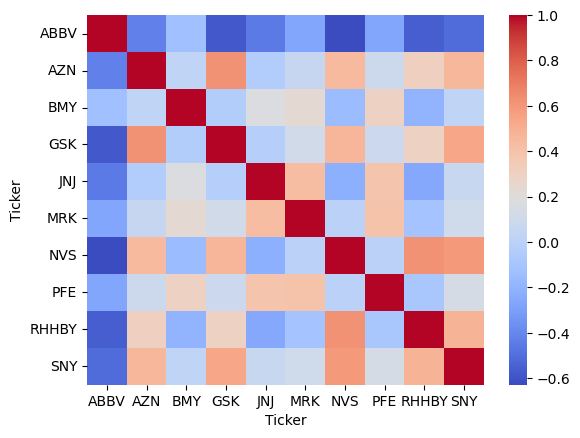

In [84]:
# Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [85]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ABBV     0.060489
AZN      0.089653
BMY      0.077946
GSK      0.077600
JNJ      0.069906
MRK      0.093365
NVS      0.075735
PFE      0.084085
RHHBY    0.077887
SNY      0.089464
dtype: float64

<Axes: ylabel='Ticker'>

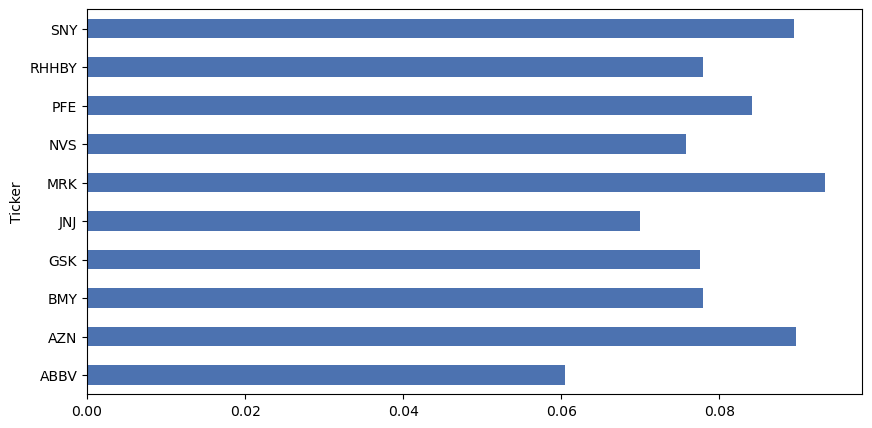

In [86]:
# What am I looking at here?
market_prior.plot.barh(figsize=(10,5))

### Integrating views

In [87]:
# You don't have to provide views on all the assets
viewdict = {'PFE': 0.1,
            'GSK': 0.1,
            'AZN': -0.05,
            'BMY': 0.25,
            'MRK': 0.09,
            'RHHBY': -0.12,
            'SNY': 0.07,
            'NVS': -0.21,
            'ABBV': 0.21,
            'JNJ': 0.2}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

#### Creating confidences

We can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [88]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.03, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (-0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [89]:
variances = []
for lb, ub in intervals: # lb: lower bound, ub: upper bound
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0012250000000000002, 0.0025000000000000005, 0.0025000000000000005, 0.010000000000000002, 0.16000000000000003, 0.0225]


### Calculate Posterior Estimate Returns

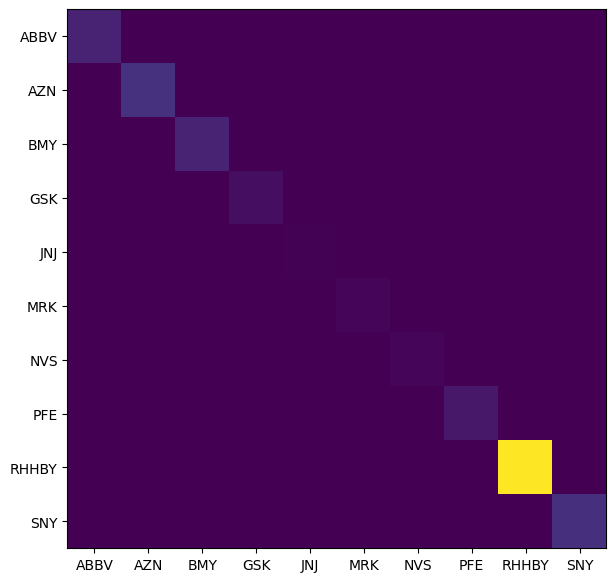

In [90]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [91]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [92]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ABBV     0.044703
AZN      0.038799
BMY      0.101859
GSK      0.040102
JNJ      0.053916
MRK      0.083479
NVS      0.009078
PFE      0.067678
RHHBY   -0.026087
SNY      0.049626
dtype: float64

In [93]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ABBV,0.060489,0.044703,0.21
AZN,0.089653,0.038799,-0.05
BMY,0.077946,0.101859,0.25
GSK,0.077600,0.040102,0.10
JNJ,0.069906,0.053916,0.20
MRK,0.093365,0.083479,0.09
NVS,0.075735,0.009078,-0.21
PFE,0.084085,0.067678,0.10
RHHBY,0.077887,-0.026087,-0.12
SNY,0.089464,0.049626,0.07


<Axes: >

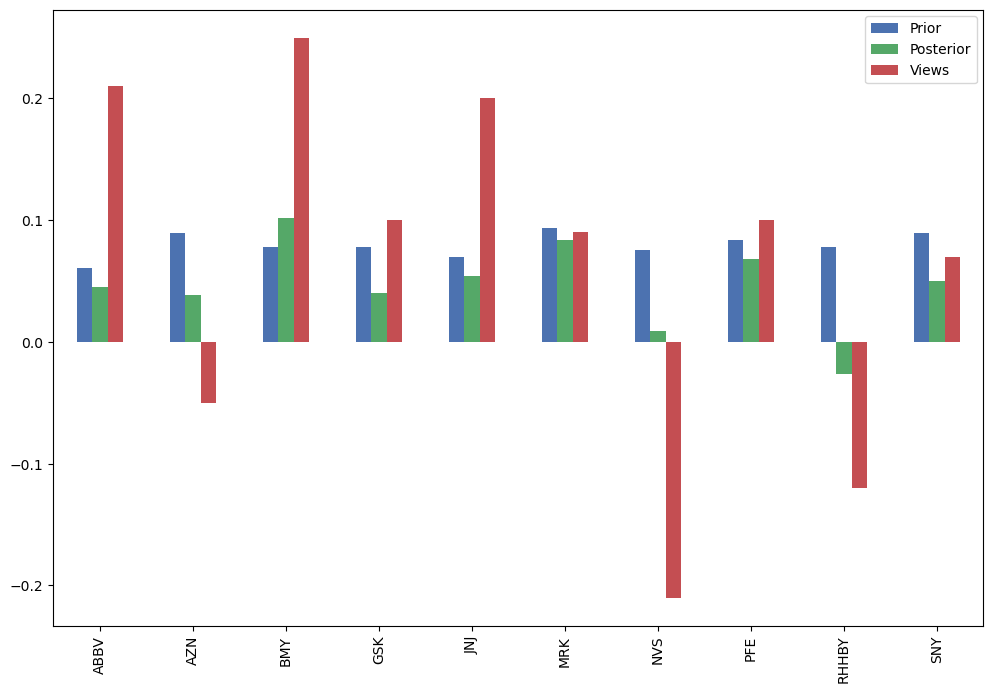

In [94]:
rets_df.plot.bar(figsize=(12,8))

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.041274  0.012560  0.015594  0.010839  0.011889  0.013595  0.011257   
AZN     0.012560  0.064196  0.024039  0.032507  0.018184  0.025264  0.026464   
BMY     0.015594  0.024039  0.057996  0.020666  0.019318  0.026833  0.018609   
GSK     0.010839  0.032507  0.020666  0.045759  0.017369  0.023813  0.023757   
JNJ     0.011889  0.018184  0.019318  0.017369  0.030072  0.022736  0.015522   
MRK     0.013595  0.025264  0.026833  0.023813  0.022736  0.063633  0.021204   
NVS     0.011257  0.026464  0.018609  0.023757  0.015522  0.021204  0.038692   
PFE     0.014568  0.025563  0.027660  0.022760  0.022078  0.030650  0.021014   
RHHBY   0.009231  0.026739  0.017714  0.023072  0.014933  0.019651  0.027273   
SNY     0.011386  0.034213  0.024698  0.031032  0.019984  0.027118  0.029378   

Ticker       PFE     RHHBY       SNY  


<Axes: >

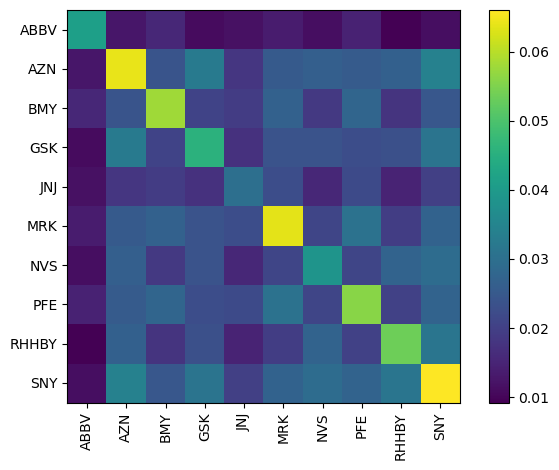

In [95]:
S_bl = bl.bl_cov()
print(S_bl)
plotting.plot_covariance(S_bl)

### Portfolio allocation

In [96]:
ef = EfficientFrontier(ret_bl, S_bl)

# A regularization term added to the optimization objective to improve the stability and robustness 
# of the optimized portfolio by penalizing extreme portfolio weights
ef.add_objective(objective_functions.L2_reg)

ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABBV', 0.0776),
             ('AZN', 0.04503),
             ('BMY', 0.2765),
             ('GSK', 0.05283),
             ('JNJ', 0.10742),
             ('MRK', 0.20687),
             ('NVS', 0.0),
             ('PFE', 0.14991),
             ('RHHBY', 0.0),
             ('SNY', 0.08384)])

<Axes: >

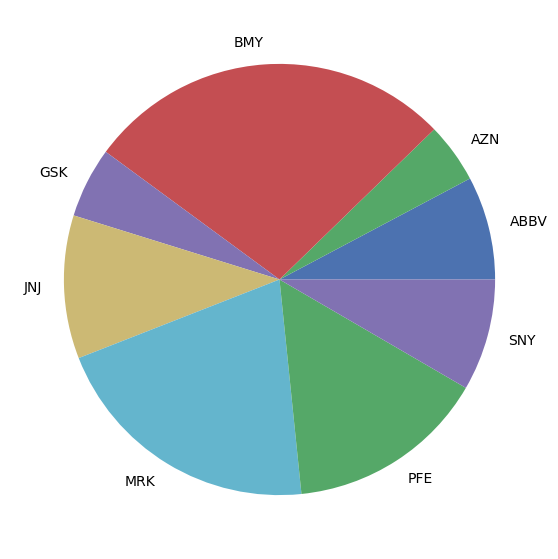

In [97]:
pd.Series(weights).plot.pie(figsize=(7,7))

Expected annual return: 7.3%
Annual volatility: 17.0%
Sharpe Ratio: 0.31


c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.07286596828089714, 0.1700642677881232, 0.3108587651508364)

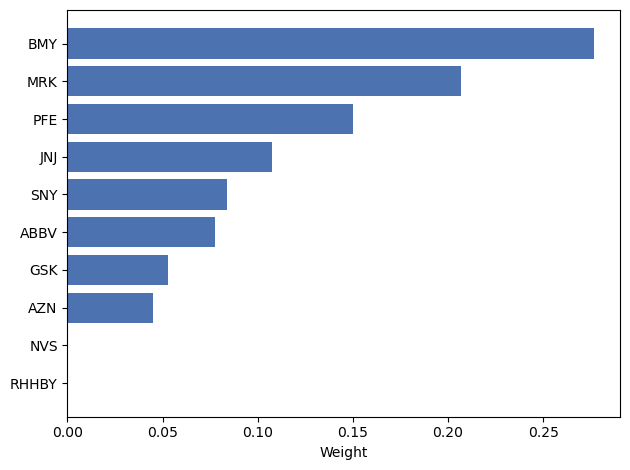

In [98]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

In [99]:
import torch

In [100]:
# Extract the posterior estimate returns from the Black-Litterman model
exp_returns = ret_bl.values
cov_matrix = S_bl.values

# Convert the posterior returns to a torch tensor
exp_returns_tensor = torch.Tensor(exp_returns).float()
cov_matrix_tensor = torch.Tensor(cov_matrix).float()

# Note and Todo:

* Note: I finshed the code in the pricing_model.py file but haven't had the time to test it.
* The trainining data you'll use has been computed in param_data folder
* read the data from the csv file and convert it to multiple torch tensor of length 6 vectors.

* TODO: Refine the model contained in the pricing_model.py

In [101]:

from pricing_model import CNNLSTMModel, huber_loss_with_fft
model = CNNLSTMModel(num_features=10, num_output_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
# ex code
for epoch in range(num_epochs):
    for batch in train_loader:
        x, y = batch  # Assuming x and y are prepared correctly
        optimizer.zero_grad()
        y_pred = model(x)
        loss = huber_loss_with_fft(y, y_pred)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

ModuleNotFoundError: No module named 'pricing_model'